In [44]:
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


def fetch_historical_data(symbol, interval='1d', start_date=None, end_date=None, limit=1000):
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    
    if start_date:
        url += f'&startTime={int(pd.Timestamp(start_date).timestamp() * 1000)}'
    if end_date:
        url += f'&endTime={int(pd.Timestamp(end_date).timestamp() * 1000)}'
    
    response = requests.get(url)
    
    if response.status_code != 200:
        raise Exception(f'Error fetching data: {response.status_code} - {response.text}')
    
    data = response.json()
    
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df.drop(columns=['close_time', 'ignore'], inplace=True)
    
    # Convert columns to numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    
    df['price_range'] = df['high'] - df['low']
    df['close_to_open'] = df['close'] - df['open']
    
    return df

# Example of fetching data
# symbol = 'BTCUSDT'  # Example: Bitcoin to USD
symbol = 'ETHUSDT'  
df = fetch_historical_data(symbol, start_date='2022-06-01', end_date='2025-02-06')
df.head()


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,price_range,close_to_open
timestamp,,,,,,,,,,,
2022-06-01,1941.90,1972.58,1763.75,1817.95,1.037841e+06,1.954005e+09,973159,502588.5150,9.472072e+08,208.83,-123.95
2022-06-02,1817.96,1853.05,1782.42,1834.08,7.887844e+05,1.434782e+09,793304,393723.5095,7.162619e+08,70.63,16.12
2022-06-03,1834.09,1843.91,1737.00,1775.12,7.412825e+05,1.319240e+09,807046,359074.7991,6.390373e+08,106.91,-58.97
2022-06-04,1775.13,1816.00,1748.43,1804.58,3.882795e+05,6.890627e+08,402734,193658.9013,3.437394e+08,67.57,29.45
2022-06-05,1804.58,1830.17,1773.05,1806.23,3.719745e+05,6.705837e+08,403935,186891.6989,3.369090e+08,57.12,1.65


In [45]:
df.shape

(982, 11)

<Axes: >

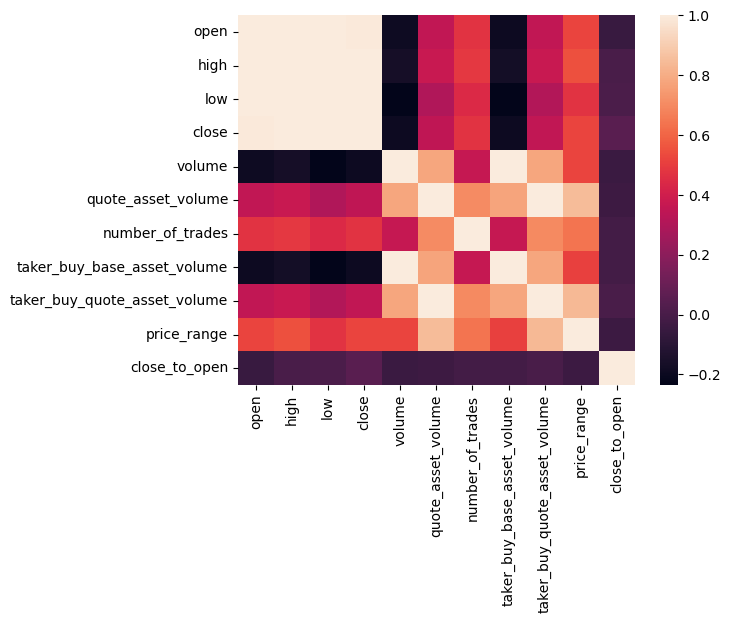

In [46]:
import seaborn as sns

sns.heatmap(df.corr())

In [47]:
# Preprocessing: Shift the target (closing price) by -1 to predict the next day's closing price
df['target'] = df['close'].shift(-1)

# Drop the last row because it will have a NaN target (due to the shift)
df = df.dropna()

features = ['open', 'high', 'low', 'volume', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'price_range', 'close_to_open']




In [48]:
X = df[features]
y = df['target']  # Target variable: next day's closing price



In [49]:
# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



In [50]:
from sklearn.preprocessing import MinMaxScaler

# Apply Min-Max scaling to the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display scaled features
pd.DataFrame(X_train_scaled, columns=X.columns).head()


,open,high,low,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,price_range,close_to_open
0,0.308430,0.296414,0.289179,0.274486,0.375565,0.263235,0.269579,0.371334,0.314854,0.249766
1,0.268054,0.256769,0.295299,0.204680,0.270633,0.205431,0.207900,0.276411,0.098426,0.396835
2,0.273309,0.253738,0.280411,0.191366,0.247283,0.209848,0.188269,0.244671,0.155242,0.317993
3,0.254101,0.244481,0.284157,0.092426,0.119929,0.079906,0.094551,0.123298,0.093634,0.410831
4,0.263695,0.249181,0.292228,0.087856,0.116195,0.080292,0.090717,0.120491,0.077269,0.381642


In [51]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [52]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
root_mean_squared_error = np.sqrt(mse)
print(f'Root Mean Squared Error: {root_mean_squared_error}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')



Root Mean Squared Error: 120.13852312438418
Mean Absolute Error: 89.8080370457496
Mean Squared Error: 14433.264738508193


In [53]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.tail()


,Actual,Predicted
timestamp,,
2025-02-01,2869.68,3175.940460
2025-02-02,2879.90,2970.795045
2025-02-03,2731.19,2960.731817
2025-02-04,2788.25,2777.321441
2025-02-05,2694.07,2835.025450


# prediction:

In [54]:
# Convert latest_data into a DataFrame with column names
latest_data_df = pd.DataFrame([X.iloc[-1]], columns=X.columns)

# Apply the MinMaxScaler transformation
latest_data_scaled = scaler.transform(latest_data_df)

# Predict the next closing price
next_close_price = model.predict(latest_data_scaled)[0]

print(f"Predicted Next Close Price: {next_close_price}")


Predicted Next Close Price: 2835.025450065221
